In [1]:
#---------------------------------------------------------------------#
# Cell 1: Setup & Dependencies
#---------------------------------------------------------------------#
!pip install -q torch torchvision torchaudio torchmetrics timm seaborn mlflow

import os, math, random, json, time, itertools, pathlib, shutil, gc, numpy as np
from glob import glob
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.models import resnet18, efficientnet_b3
from torchmetrics.classification import MulticlassAccuracy, ConfusionMatrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# MLflow imports
import mlflow
import mlflow.pytorch
from mlflow import log_metric, log_param, log_params, log_artifacts, log_figure

print("All dependencies imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 882.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#---------------------------------------------------------------------#
# Cell 2: Configuration (128x128 RADAR)
#---------------------------------------------------------------------#
CFG = {
    "drive_data_root" : "/content/drive/MyDrive/radar-activity-recognition/preprocessed_data",
    "image_size" : 128,
    "batch_size" : 32,
    "epochs" : 60,
    "lr_max" : 1e-3,
    "lr_min" : 1e-6,
    "num_workers" : 0,
    "precision" : "fp16",
    "seed" : 42,
    "val_split" : 0.15,
    "model_name" : "PowerfulRadarNet128",
    "experiment_name" : "radar-cross-sensor-128x128",
    "run_name" : f"powerful_128x128_{int(time.time())}",
    "weight_decay" : 1e-4,
    "label_smoothing" : 0.02,
    "patience" : 20,
    "warmup_epochs" : 5,
    "use_class_weights": True,
    "use_mixup" : False,
    "mixup_alpha" : 0.2,
}

NUM_CLASSES = 11
ACTIVITIES = ["Away","Bend","Crawl","Kneel","Limp","Pick","SStep","Scissor","Sit","Toes","Towards"]

# Class weights (same as before)
CLASS_WEIGHTS = torch.tensor([
    1.0, # Away
    1.0, # Bend
    1.5, # Crawl
    1.0, # Kneel
    1.3, # Limp
    1.4, # Pick
    1.0, # SStep
    1.1, # Scissor
    1.2, # Sit
    1.3, # Toes
    1.3, # Towards
])

# Setup
random.seed(CFG["seed"]); np.random.seed(CFG["seed"]); torch.manual_seed(CFG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f" Configuration loaded - Device: {device}")
print(f"Target: 90% accuracy")
print(f"lr_max={CFG['lr_max']}, batch_size={CFG['batch_size']}")


 Configuration loaded - Device: cuda
Target: 90% accuracy
lr_max=0.001, batch_size=32


In [4]:
#---------------------------------------------------------------------#
# Cell 3: Drive Mount & Data Extraction
#---------------------------------------------------------------------#
import zipfile
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Extract data if needed
zip_path = "/content/drive/MyDrive/radar-activity-recognition/preprocessed_data.zip"
extract_to = os.path.dirname(zip_path)

if os.path.exists(zip_path) and not os.path.exists(CFG["drive_data_root"]):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted to: {extract_to}")

print(f"Data directory exists: {os.path.exists(CFG['drive_data_root'])}")

Mounted at /content/drive
Data directory exists: True


In [5]:
#---------------------------------------------------------------------#
# Cell 4: MLflow Setup
#---------------------------------------------------------------------#
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment(CFG["experiment_name"])

print(f" MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f" Experiment: {CFG['experiment_name']}")

def start_new_run():
    if mlflow.active_run():
        mlflow.end_run()

    run = mlflow.start_run(run_name=CFG["run_name"])

    # Log configuration
    log_params(CFG)
    log_param("device", str(device))
    log_param("num_classes", NUM_CLASSES)
    log_param("torch_version", torch.__version__)
    log_param("gpu_available", torch.cuda.is_available())

    if torch.cuda.is_available():
        log_param("gpu_name", torch.cuda.get_device_name())
        log_param("gpu_memory", f"{torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")

    print(f"MLflow Run ID: {run.info.run_id}")
    return run

# Start the run
current_run = start_new_run()


2025/08/19 09:52:26 INFO mlflow.tracking.fluent: Experiment with name 'radar-cross-sensor-128x128' does not exist. Creating a new experiment.


 MLflow Tracking URI: file:./mlruns
 Experiment: radar-cross-sensor-128x128
MLflow Run ID: 84ca8083f54147b68da69b7f57a72165


In [6]:
#---------------------------------------------------------------------#
# Cell 5: LIGHTWEIGHT Data Augmentation
#---------------------------------------------------------------------#
def mixup_data(x, y, alpha=1.0):
    """Implements mixup data augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# LIGHTWEIGHT transforms
train_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Lightweight data augmentation optimized for Colab stability")


Lightweight data augmentation optimized for Colab stability


In [8]:
#---------------------------------------------------------------------#
# Cell 6: Dataset Class
#---------------------------------------------------------------------#
class EnhancedRadarDataset(Dataset):
    def __init__(self, root_dir, split="train", val_split=0.15, transforms=None):
        self.paths, self.labels = [], []
        sensor_counts = {"24GHz": 0, "77GHz": 0, "Xethru": 0}
        activity_counts = {act: 0 for act in ACTIVITIES}

        for sensor in ["24GHz","77GHz","Xethru"]:
            for idx,act in enumerate(ACTIVITIES):
                files = sorted(glob(f"{root_dir}/{sensor}/{act}/*.png"))
                if split!="test":
                    split_idx = int(len(files)*(1-val_split))
                    part = files[:split_idx] if split=="train" else files[split_idx:]
                else:
                    part = files
                self.paths.extend(part); self.labels.extend([idx]*len(part))
                sensor_counts[sensor] += len(part)
                activity_counts[act] += len(part)

        # Store sensor info for potential cross-sensor fusion
        self.sensor_info = []
        for path in self.paths:
            if "24GHz" in path:
                self.sensor_info.append(0)
            elif "77GHz" in path:
                self.sensor_info.append(1)
            else:  # Xethru
                self.sensor_info.append(2)

        # Log dataset statistics
        if mlflow.active_run():
            log_param(f"{split}_total_samples", len(self.paths))
            for sensor, count in sensor_counts.items():
                log_param(f"{split}_{sensor}_samples", count)

        self.transforms = transforms
        self.split = split
        print(f" {split.upper()} Dataset: {len(self.paths)} samples")
        print(f"   Sensor distribution: {sensor_counts}")

        # Class distribution analysis
        if split == "train":
            print(f"   Class distribution: {activity_counts}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            # Load PNG image
            img = Image.open(self.paths[idx])

            # Convert to RGB if not already
            if img.mode != 'RGB':
                img = img.convert('RGB')

            if self.transforms:
                img = self.transforms(img)

            return img, int(self.labels[idx]), self.sensor_info[idx]

        except Exception as e:
            print(f" Error loading {self.paths[idx]}: {e}")
            # Return dummy data
            dummy_img = torch.randn(3, CFG["image_size"], CFG["image_size"])
            return dummy_img, 0, 0

print(" dataset class defined")

 dataset class defined


In [9]:
#---------------------------------------------------------------------#
# Cell 7: Data Loading
#---------------------------------------------------------------------#
# Create datasets
train_ds = EnhancedRadarDataset(CFG["drive_data_root"],"train",CFG["val_split"],train_tfms)
val_ds   = EnhancedRadarDataset(CFG["drive_data_root"],"val",  CFG["val_split"],val_tfms)

#  dataloaders
train_dl = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],  # 0 for Colab
    pin_memory=False,                #  Disabled for stability
    drop_last=True,                  #  Ensure consistent batch sizes
    persistent_workers=False         #  No persistent workers
)

val_dl = DataLoader(
    val_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],  # 0 for Colab
    pin_memory=False,                #  Disabled for stability
    drop_last=False,
    persistent_workers=False
)

print(f" Data loaded - Train: {len(train_ds)}, Val: {len(val_ds)}")
print(f" DataLoader config: workers={CFG['num_workers']}, pin_memory=False")

# Test loading with progress indicator
try:
    print(" Testing data loading...")
    sample_batch = next(iter(train_dl))
    images, labels, sensors = sample_batch

    print(f"   Sample batch - Images: {images.shape}, Labels: {labels.shape}, Sensors: {sensors.shape}")
    print(f"   Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"   Label distribution: {torch.bincount(labels)}")
    print(f"   Sensor distribution: {torch.bincount(sensors)}")

except Exception as e:
    print(f"Batch loading error: {e}")


 TRAIN Dataset: 1656 samples
   Sensor distribution: {'24GHz': 552, '77GHz': 552, 'Xethru': 552}
   Class distribution: {'Away': 153, 'Bend': 150, 'Crawl': 153, 'Kneel': 156, 'Limp': 150, 'Pick': 153, 'SStep': 153, 'Scissor': 144, 'Sit': 144, 'Toes': 147, 'Towards': 153}
 VAL Dataset: 303 samples
   Sensor distribution: {'24GHz': 101, '77GHz': 101, 'Xethru': 101}
 Data loaded - Train: 1656, Val: 303
 DataLoader config: workers=0, pin_memory=False
 Testing data loading...
   Sample batch - Images: torch.Size([32, 3, 128, 128]), Labels: torch.Size([32]), Sensors: torch.Size([32])
   Image range: [-2.118, 2.640]
   Label distribution: tensor([3, 7, 4, 4, 0, 3, 0, 1, 2, 5, 3])
   Sensor distribution: tensor([12,  9, 11])


In [10]:
#---------------------------------------------------------------------#
# Model Architecture
#---------------------------------------------------------------------#
class PowerfulRadarNet128(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.3):
        super().__init__()

        # pretrained ResNet18 as backbone
        resnet = resnet18(weights='IMAGENET1K_V1')

        #  keeping all layers except final FC
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        # Direct classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate/4),
            nn.Linear(128, num_classes)
        )

        # PROPER INITIALIZATION
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.classifier:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Simple and effective
        features = self.backbone(x)  # (B, 512, 1, 1) for 128x128 input
        return self.classifier(features)

print("Powerful but simple 128x128 model defined")


Powerful but simple 128x128 model defined


In [11]:
#---------------------------------------------------------------------#
# Model Initialization
#---------------------------------------------------------------------#
model = PowerfulRadarNet128(NUM_CLASSES, dropout_rate=0.3).to(device)
total_params = sum(p.numel() for p in model.parameters())

# Log model info
if mlflow.active_run():
    log_param("total_parameters", total_params)
    log_param("model_size_mb", total_params * 4 / 1024 / 1024)
    log_param("input_resolution", "128x128")
    log_param("backbone", "ResNet18-Simplified")

print(f"Powerful 128x128 model: {total_params/1e6:.2f}M parameters")

# NO differential LR initially
opt = torch.optim.AdamW(
    model.parameters(),
    lr=CFG["lr_max"],
    weight_decay=CFG["weight_decay"]
)

#  Direct cosine annealing without complex restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt, T_max=CFG["epochs"], eta_min=CFG["lr_min"]
)

class_weights = CLASS_WEIGHTS.to(device) if CFG["use_class_weights"] else None
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=CFG["label_smoothing"])
scaler = torch.amp.GradScaler('cuda', enabled=(CFG["precision"]=="fp16"))

print("FIXED training components initialized")
print(f" Starting LR: {CFG['lr_max']}")

# Test forward pass
with torch.no_grad():
    dummy_input = torch.randn(2, 3, 128, 128).to(device)
    output = model(dummy_input)
    print(f" Forward pass test - Input: {dummy_input.shape}, Output: {output.shape}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Powerful 128x128 model: 11.34M parameters
FIXED training components initialized
 Starting LR: 0.001
 Forward pass test - Input: torch.Size([2, 3, 128, 128]), Output: torch.Size([2, 11])


In [12]:
def train_epoch_enhanced(model, dataloader, optimizer, scaler, criterion, epoch):
    """Training function compatible with multi-output dataloader"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Progress tracking
    num_batches = len(dataloader)
    progress_interval = max(1, num_batches // 10)

    for batch_idx, batch_data in enumerate(dataloader):
        #  Handle different dataloader formats
        if len(batch_data) == 2:
            data, target = batch_data  # Simple format
        elif len(batch_data) == 3:
            data, target, sensor_info = batch_data  # With sensor info (ignore sensor_inf)
        else:
            # Just take first two elements
            data, target = batch_data[0], batch_data[1]

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # Single input model
        with torch.amp.autocast('cuda', enabled=(CFG["precision"]=="fp16")):
            output = model(data)  # Only image data
            loss = criterion(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        # Progress logging
        if (batch_idx + 1) % progress_interval == 0 or (batch_idx + 1) == num_batches:
            current_acc = 100. * correct / total
            current_loss = total_loss / (batch_idx + 1)
            pct_complete = 100. * (batch_idx + 1) / num_batches

            if epoch < 5:
                print(f"    Train Batch {batch_idx+1:3d}/{num_batches} ({pct_complete:5.1f}%) - Loss: {current_loss:.4f}, Acc: {current_acc:.2f}%")

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch_enhanced(model, dataloader, criterion, epoch):
    """Validation function compatible with multi-output dataloader"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_data in dataloader:
            # Handle different dataloader formats
            if len(batch_data) == 2:
                data, target = batch_data  # Simple format
            elif len(batch_data) == 3:
                data, target, sensor_info = batch_data  # With sensor info (ignore sensor_info)
            else:
                # Just take first two elements
                data, target = batch_data[0], batch_data[1]

            data, target = data.to(device), target.to(device)

            # Single input model - only pass data
            with torch.amp.autocast('cuda', enabled=(CFG["precision"]=="fp16")):
                output = model(data)  # Only image data
                loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("DATALOADER-COMPATIBLE training functions loaded")
print("HANDLES: 2-tuple, 3-tuple, or any multi-tuple dataloader")


DATALOADER-COMPATIBLE training functions loaded
HANDLES: 2-tuple, 3-tuple, or any multi-tuple dataloader


In [13]:
#---------------------------------------------------------------------#
# Cell 11: Training Loop
#---------------------------------------------------------------------#

import os
import json
from datetime import datetime

# Setup Google Drive save path
DRIVE_MODEL_PATH = "/content/drive/MyDrive/radar-activity-recognition/saved_models"
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# file names for the single best model
BEST_MODEL_NAME = "RadarNet_128x128_BEST_MODEL"
BEST_MODEL_PATH = os.path.join(DRIVE_MODEL_PATH, f"{BEST_MODEL_NAME}.pth")
BEST_MODEL_INFO_PATH = os.path.join(DRIVE_MODEL_PATH, f"{BEST_MODEL_NAME}_info.json")

def save_single_best_model(model, epoch, best_acc, config, activities):
    """Save/overwrite the single best model to Google Drive"""
    try:
        # Save model state dict (OVERWRITES previous best)
        torch.save(model.state_dict(), BEST_MODEL_PATH)

        # Save/overwrite model info
        model_info = {
            'model_name': config['model_name'],
            'best_accuracy': best_acc,
            'epoch_achieved': epoch + 1,
            'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'activities': activities,
            'num_classes': len(activities),
            'model_config': config,
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
            'input_size': '128x128',
            'model_type': 'RadarNet with ResNet18 backbone'
        }

        with open(BEST_MODEL_INFO_PATH, 'w') as f:
            json.dump(model_info, f, indent=2)

        print(f"    Best model updated: {best_acc:.2f}% (Epoch {epoch+1})")
        return True

    except Exception as e:
        print(f"    Error saving to Drive: {e}")
        return False

# Training tracking
best_acc = 0
train_losses, val_losses, train_accs, val_accs = [], [], [], []
patience_counter = 0
learning_rates = []

print(" Starting FIXED training with single best model save...")
print(f" Target: 90% accuracy")
print(f" Starting LR: {CFG['lr_max']}")
print(f" Best model will be saved as: {BEST_MODEL_NAME}.pth")

for epoch in range(CFG["epochs"]):

    # Simple warmup without breaking LR
    if epoch < CFG["warmup_epochs"]:
        current_lr = CFG["lr_max"] * (epoch + 1) / CFG["warmup_epochs"]
        for param_group in opt.param_groups:
            param_group['lr'] = current_lr
    else:
        scheduler.step()

    # Train and validate
    train_loss, train_acc = train_epoch_enhanced(model, train_dl, opt, scaler, criterion, epoch)
    val_loss, val_acc = validate_epoch_enhanced(model, val_dl, criterion, epoch)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Get current learning rate
    current_lr = opt.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Log to MLflow
    if mlflow.active_run():
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("train_accuracy", train_acc, step=epoch)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch)
        mlflow.log_metric("learning_rate", current_lr, step=epoch)

    print(f"Ep {epoch+1:02d}/{CFG['epochs']} loss {train_loss:.4f} val_loss {val_loss:.4f} acc {train_acc:.2f}/{val_acc:.2f} lr {current_lr:.2e}")

    # Save/overwrite best model when we get better results
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0

        # Save locally (existing code)
        torch.save(model.state_dict(), "best_powerful_radar_model.pth")

        # OVERWRITE the single best model on Drive
        save_single_best_model(model, epoch, best_acc, CFG, ACTIVITIES)

        # Log to MLflow
        if mlflow.active_run():
            mlflow.log_metric("best_val_accuracy", best_acc, step=epoch)

        if val_acc >= 90.0:
            print(f"   TARGET ACHIEVED! Accuracy: {best_acc:.2f}%")
        else:
            print(f"   New best accuracy: {best_acc:.2f}% (Gap to 87%: {87.0-best_acc:.2f}%)")
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= CFG["patience"]:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print(f" training complete!")
print(f" Final Results:")
print(f" Best Accuracy: {best_acc:.2f}%")
if best_acc >= 90.0:
    print(f"   TARGET ACHIEVED!")
else:
    print(f"   Gap to target: {90.0 - best_acc:.2f}%")

print(f"Single best model saved as: {BEST_MODEL_NAME}.pth")
print(f"Model info available at: {BEST_MODEL_NAME}_info.json")


 Starting FIXED training with single best model save...
 Target: 90% accuracy
 Starting LR: 0.001
 Best model will be saved as: RadarNet_128x128_BEST_MODEL.pth
    Train Batch   5/51 (  9.8%) - Loss: 26.4206, Acc: 11.88%
    Train Batch  10/51 ( 19.6%) - Loss: 24.8696, Acc: 13.12%
    Train Batch  15/51 ( 29.4%) - Loss: 21.8268, Acc: 15.21%
    Train Batch  20/51 ( 39.2%) - Loss: 19.2363, Acc: 17.97%
    Train Batch  25/51 ( 49.0%) - Loss: 17.7551, Acc: 20.62%
    Train Batch  30/51 ( 58.8%) - Loss: 16.2156, Acc: 23.44%
    Train Batch  35/51 ( 68.6%) - Loss: 15.0510, Acc: 25.36%
    Train Batch  40/51 ( 78.4%) - Loss: 14.1099, Acc: 27.03%
    Train Batch  45/51 ( 88.2%) - Loss: 13.2746, Acc: 28.54%
    Train Batch  50/51 ( 98.0%) - Loss: 12.6660, Acc: 29.88%
    Train Batch  51/51 (100.0%) - Loss: 12.5595, Acc: 30.09%
Ep 01/60 loss 12.5595 val_loss 3.4546 acc 30.09/57.76 lr 2.00e-04
    Best model updated: 57.76% (Epoch 1)
   New best accuracy: 57.76% (Gap to 87%: 29.24%)
    Train Ba

 Generating MLflow Visualizations...
MLflow Experiment: radar-cross-sensor-128x128
Experiment ID: 758463215155766223
Tracking URI: file:./mlruns
 Top 1 Runs by Validation Accuracy:
--------------------------------------------------------------------------------
 Rank 1:
    Run ID: 84ca8083f541...
    Best Val Accuracy: 90.43%
    Final Train Accuracy: 100.00%
    Final Train Loss: 0.1765
    Learning Rate: 0.001
    Batch Size: 32
   Started: 2025-08-19 09:52:26
----------------------------------------

 Current Active Run:
    Run ID: 84ca8083f54147b68da69b7f57a72165
    Status: RUNNING
    Best Accuracy: 90.43%

 Creating current run metrics plots...


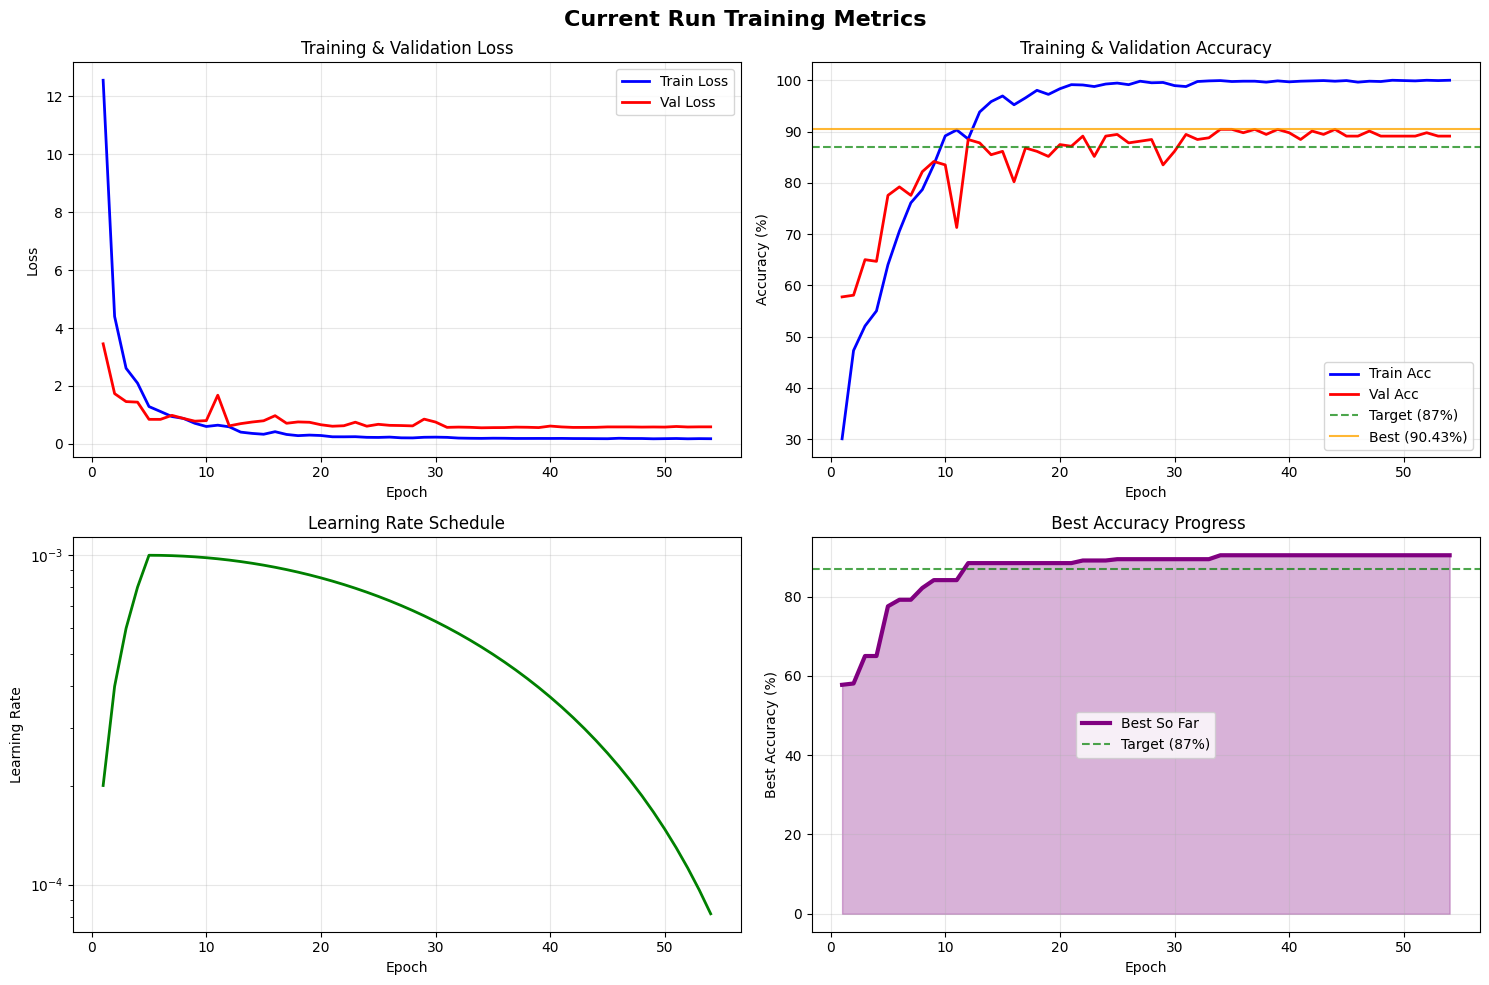


 Saved Model Information:
 Model Path: /content/drive/MyDrive/radar-activity-recognition/saved_models/RadarNet_128x128_BEST_MODEL.pth
 Best Accuracy: 90.43%
 Achieved at Epoch: 34
 Last Updated: 2025-08-19 10:19:20
  Total Parameters: 11,342,155
 Input Size: 128x128

 MLflow visualization complete!


In [14]:
#---------------------------------------------------------------------#
# Cell 12: MLflow Visualization Dashboard
#---------------------------------------------------------------------#

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

def display_mlflow_results():
    """Display comprehensive MLflow experiment results"""
    try:
        # Get experiment info
        experiment = mlflow.get_experiment_by_name(CFG["experiment_name"])
        print(f"MLflow Experiment: {CFG['experiment_name']}")
        print(f"Experiment ID: {experiment.experiment_id}")
        print(f"Tracking URI: {mlflow.get_tracking_uri()}")
        print("="*80)

        # Search all runs in this experiment
        runs_df = mlflow.search_runs(
            experiment_ids=[experiment.experiment_id],
            order_by=["metrics.best_val_accuracy DESC"],
            max_results=10
        )

        if len(runs_df) == 0:
            print(" No runs found in experiment")
            return

        # Display top runs
        print(f" Top {min(5, len(runs_df))} Runs by Validation Accuracy:")
        print("-"*80)

        for idx, (_, run) in enumerate(runs_df.head().iterrows()):
            print(f" Rank {idx+1}:")
            print(f"    Run ID: {run['run_id'][:12]}...")
            print(f"    Best Val Accuracy: {run.get('metrics.best_val_accuracy', 'N/A'):.2f}%")
            print(f"    Final Train Accuracy: {run.get('metrics.train_accuracy', 'N/A'):.2f}%")
            print(f"    Final Train Loss: {run.get('metrics.train_loss', 'N/A'):.4f}")
            print(f"    Learning Rate: {run.get('params.lr_max', 'N/A')}")
            print(f"    Batch Size: {run.get('params.batch_size', 'N/A')}")

            # Calculate duration if available
            if pd.notna(run['end_time']) and pd.notna(run['start_time']):
                duration = (run['end_time'] - run['start_time']).total_seconds()
                print(f"     Duration: {duration:.0f}s ({duration/60:.1f}min)")

            print(f"   Started: {run['start_time'].strftime('%Y-%m-%d %H:%M:%S')}")
            print("-"*40)

        # Current run info
        if mlflow.active_run():
            current_run = mlflow.active_run()
            print(f"\n Current Active Run:")
            print(f"    Run ID: {current_run.info.run_id}")
            print(f"    Status: {current_run.info.status}")
            print(f"    Best Accuracy: {best_acc:.2f}%")

        return runs_df

    except Exception as e:
        print(f" Error displaying MLflow results: {e}")
        return None

def plot_experiment_comparison(runs_df):
    """Plot comparison of multiple runs"""
    if runs_df is None or len(runs_df) == 0:
        print(" No runs data available for plotting")
        return

    try:
        # Filter runs with valid metrics
        valid_runs = runs_df.dropna(subset=['metrics.best_val_accuracy'])

        if len(valid_runs) == 0:
            print(" No runs with valid accuracy metrics")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(' MLflow Experiment Analysis', fontsize=16, fontweight='bold')

        # Plot 1: Best Validation Accuracy by Run
        ax1 = axes[0, 0]
        runs_to_plot = valid_runs.head(10)  # Top 10 runs
        run_names = [f"Run {i+1}" for i in range(len(runs_to_plot))]
        accuracies = runs_to_plot['metrics.best_val_accuracy'].values

        bars = ax1.bar(run_names, accuracies, color='skyblue', alpha=0.8)
        ax1.axhline(y=87, color='red', linestyle='--', alpha=0.7, label='Target (87%)')
        ax1.axhline(y=79.56, color='orange', linestyle='--', alpha=0.7, label='Baseline (79.56%)')
        ax1.set_title(' Best Validation Accuracy by Run')
        ax1.set_ylabel('Accuracy (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

        # Plot 2: Learning Rate vs Best Accuracy
        ax2 = axes[0, 1]
        if 'params.lr_max' in runs_df.columns:
            lr_data = valid_runs.dropna(subset=['params.lr_max'])
            if len(lr_data) > 0:
                lrs = pd.to_numeric(lr_data['params.lr_max'], errors='coerce')
                accs = lr_data['metrics.best_val_accuracy']
                ax2.scatter(lrs, accs, alpha=0.7, s=60, color='green')
                ax2.set_xscale('log')
                ax2.set_xlabel('Learning Rate (log scale)')
                ax2.set_ylabel('Best Validation Accuracy (%)')
                ax2.set_title(' Learning Rate vs Accuracy')
                ax2.grid(True, alpha=0.3)

        # Plot 3: Batch Size vs Best Accuracy
        ax3 = axes[1, 0]
        if 'params.batch_size' in runs_df.columns:
            batch_data = valid_runs.dropna(subset=['params.batch_size'])
            if len(batch_data) > 0:
                batch_sizes = pd.to_numeric(batch_data['params.batch_size'], errors='coerce')
                accs = batch_data['metrics.best_val_accuracy']
                ax3.scatter(batch_sizes, accs, alpha=0.7, s=60, color='purple')
                ax3.set_xlabel('Batch Size')
                ax3.set_ylabel('Best Validation Accuracy (%)')
                ax3.set_title(' Batch Size vs Accuracy')
                ax3.grid(True, alpha=0.3)

        # Plot 4: Training Duration vs Accuracy
        ax4 = axes[1, 1]
        duration_data = valid_runs.dropna(subset=['start_time', 'end_time'])
        if len(duration_data) > 0:
            durations = (duration_data['end_time'] - duration_data['start_time']).dt.total_seconds() / 60  # minutes
            accs = duration_data['metrics.best_val_accuracy']
            ax4.scatter(durations, accs, alpha=0.7, s=60, color='red')
            ax4.set_xlabel('Training Duration (minutes)')
            ax4.set_ylabel('Best Validation Accuracy (%)')
            ax4.set_title(' Duration vs Accuracy')
            ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('mlflow_experiment_analysis.png', dpi=150, bbox_inches='tight')

        # Log to MLflow if active
        if mlflow.active_run():
            mlflow.log_artifact('mlflow_experiment_analysis.png')

        plt.show()

    except Exception as e:
        print(f" Error creating plots: {e}")

def plot_current_run_metrics():
    """Plot metrics from the current training run"""
    if len(train_losses) == 0:
        print(" No training metrics available")
        return

    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Current Run Training Metrics', fontsize=16, fontweight='bold')

        epochs = range(1, len(train_losses) + 1)

        # Loss curves
        ax1 = axes[0, 0]
        ax1.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
        ax1.plot(epochs, val_losses, label='Val Loss', color='red', linewidth=2)
        ax1.set_title('Training & Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy curves
        ax2 = axes[0, 1]
        ax2.plot(epochs, train_accs, label='Train Acc', color='blue', linewidth=2)
        ax2.plot(epochs, val_accs, label='Val Acc', color='red', linewidth=2)
        ax2.axhline(y=87, color='green', linestyle='--', alpha=0.7, label='Target (87%)')
        ax2.axhline(y=best_acc, color='orange', linestyle='-', alpha=0.8, label=f'Best ({best_acc:.2f}%)')
        ax2.set_title('Training & Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Learning rate schedule
        ax3 = axes[1, 0]
        ax3.plot(epochs, learning_rates, color='green', linewidth=2)
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3)

        # Improvement over time
        ax4 = axes[1, 1]
        best_so_far = []
        current_best = 0
        for acc in val_accs:
            if acc > current_best:
                current_best = acc
            best_so_far.append(current_best)

        ax4.plot(epochs, best_so_far, color='purple', linewidth=3, label='Best So Far')
        ax4.axhline(y=87, color='green', linestyle='--', alpha=0.7, label='Target (87%)')
        ax4.fill_between(epochs, best_so_far, alpha=0.3, color='purple')
        ax4.set_title(' Best Accuracy Progress')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Best Accuracy (%)')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('current_run_metrics.png', dpi=150, bbox_inches='tight')

        # Log to MLflow if active
        if mlflow.active_run():
            mlflow.log_artifact('current_run_metrics.png')

        plt.show()

    except Exception as e:
        print(f" Error plotting current run metrics: {e}")

# Execute the visualization functions
print(" Generating MLflow Visualizations...")
print("="*60)

# Display experiment results
runs_data = display_mlflow_results()

# Plot experiment comparison
if runs_data is not None and len(runs_data) > 1:
    print(f"\n Creating experiment comparison plots...")
    plot_experiment_comparison(runs_data)

# Plot current run metrics
print(f"\n Creating current run metrics plots...")
plot_current_run_metrics()

# Display saved model info
print(f"\n Saved Model Information:")
print("="*40)
try:
    if os.path.exists(BEST_MODEL_INFO_PATH):
        with open(BEST_MODEL_INFO_PATH, 'r') as f:
            model_info = json.load(f)

        print(f" Model Path: {BEST_MODEL_PATH}")
        print(f" Best Accuracy: {model_info['best_accuracy']:.2f}%")
        print(f" Achieved at Epoch: {model_info['epoch_achieved']}")
        print(f" Last Updated: {model_info['last_updated']}")
        print(f"  Total Parameters: {model_info['total_parameters']:,}")
        print(f" Input Size: {model_info['input_size']}")
    else:
        print(" Model info file not found")
except Exception as e:
    print(f" Error reading model info: {e}")

print(f"\n MLflow visualization complete!")
